In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
import os, shutil, random


In [26]:
# Paths
base_dir = "D:/PlantDiseaseDetection/dataset/PlantVillage"   # ✅ simpler and consistent
output_dir = "D:/PlantDiseaseDetection/dataset_split"

# Train/val/test ratio
train_split = 0.7
val_split = 0.15
test_split = 0.15

# Make output directories
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(output_dir, split), exist_ok=True)

# Split and copy files
for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    n_total = len(images)
    n_train = int(train_split * n_total)
    n_val = int(val_split * n_total)

    train_imgs = images[:n_train]
    val_imgs = images[n_train:n_train + n_val]
    test_imgs = images[n_train + n_val:]

    for split, split_imgs in zip(["train", "val", "test"], [train_imgs, val_imgs, test_imgs]):
        split_class_dir = os.path.join(output_dir, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)
        for img in split_imgs:
            src = os.path.join(class_path, img)
            dst = os.path.join(split_class_dir, img)
            if os.path.isfile(src):
                shutil.copy(src, dst)

print("✅ Dataset successfully split into train/val/test!")


✅ Dataset successfully split into train/val/test!


In [27]:
train_dir = "D:/PlantDiseaseDetection/dataset_split/train"
val_dir   = "D:/PlantDiseaseDetection/dataset_split/val"
test_dir  = "D:/PlantDiseaseDetection/dataset_split/test"

print("Train dir:", train_dir)
print("Val dir:", val_dir)
print("Test dir:", test_dir)

Train dir: D:/PlantDiseaseDetection/dataset_split/train
Val dir: D:/PlantDiseaseDetection/dataset_split/val
Test dir: D:/PlantDiseaseDetection/dataset_split/test


In [28]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # ✅ Use ResNet preprocessing
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False  # ✅ Keep consistent order
)

test_gen = val_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False  # ✅ Important for evaluation
)


Found 14440 images belonging to 15 classes.
Found 3089 images belonging to 15 classes.
Found 3109 images belonging to 15 classes.


In [29]:
num_classes = len(train_gen.class_indices)

base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# ✅ Freeze most layers initially (fine-tune later)
for layer in base_model.layers[:-50]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
preds = Dense(num_classes, activation="softmax")(x)

resnet_model = Model(inputs=base_model.input, outputs=preds)

resnet_model.compile(
    optimizer=Adam(1e-4),   # ✅ slightly higher LR for new top layers
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

resnet_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,116,111 (92.00 MB)

 Trainable params: 17,478,927 (66.68 MB)

 Non-trainable params: 6,637,184 (25.32 MB)

In [31]:
EPOCHS = 25

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-7)
]

history = resnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/25
452/452 ━━━━━━━━━━━━━━━━━━━━ 550s 1s/step - accuracy: 0.6769 - loss: 1.0837 - val_accuracy: 0.8757 - val_loss: 0.3889 - learning_rate: 1.0000e-05
Epoch 2/25
452/452 ━━━━━━━━━━━━━━━━━━━━ 509s 1s/step - accuracy: 0.8528 - loss: 0.4712 - val_accuracy: 0.9213 - val_loss: 0.2372 - learning_rate: 1.0000e-05
Epoch 3/25
452/452 ━━━━━━━━━━━━━━━━━━━━ 501s 1s/step - accuracy: 0.9040 - loss: 0.3065 - val_accuracy: 0.9469 - val_loss: 0.1592 - learning_rate: 1.0000e-05
Epoch 4/25
452/452 ━━━━━━━━━━━━━━━━━━━━ 506s 1s/step - accuracy: 0.9280 - loss: 0.2300 - val_accuracy: 0.9550 - val_loss: 0.1329 - learning_rate: 1.0000e-05
Epoch 5/25
452/452 ━━━━━━━━━━━━━━━━━━━━ 498s 1s/step - accuracy: 0.9452 - loss: 0.1765 - val_accuracy: 0.9650 - val_loss: 0.1031 - learning_rate: 1.0000e-05
Epoch 6/25
452/452 ━━━━━━━━━━━━━━━━━━━━ 507s 1s/step - accuracy: 0.9532 - loss: 0.1448 - val_accuracy: 0.9705 - val_loss: 0.0867 - learning_rate: 1.0000e-05
Epoch 7/25
452/452 ━━━━━━━━━━━━━━━━━━━━ 493s 1s/step - acc

In [32]:
for layer in base_model.layers[-50:]:
    layer.trainable = True

resnet_model.compile(
    optimizer=Adam(1e-5),  
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

fine_tune_epochs = 10

history_fine = resnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=fine_tune_epochs,
    callbacks=callbacks
)


Epoch 1/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 10083s 22s/step - accuracy: 0.9873 - loss: 0.0384 - val_accuracy: 0.9864 - val_loss: 0.0416 - learning_rate: 1.0000e-05
Epoch 2/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 505s 1s/step - accuracy: 0.9896 - loss: 0.0341 - val_accuracy: 0.9877 - val_loss: 0.0378 - learning_rate: 1.0000e-05
Epoch 3/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 480s 1s/step - accuracy: 0.9905 - loss: 0.0307 - val_accuracy: 0.9877 - val_loss: 0.0369 - learning_rate: 1.0000e-05
Epoch 4/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 479s 1s/step - accuracy: 0.9914 - loss: 0.0292 - val_accuracy: 0.9845 - val_loss: 0.0474 - learning_rate: 1.0000e-05
Epoch 5/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 480s 1s/step - accuracy: 0.9896 - loss: 0.0319 - val_accuracy: 0.9877 - val_loss: 0.0436 - learning_rate: 1.0000e-05
Epoch 6/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 479s 1s/step - accuracy: 0.9917 - loss: 0.0265 - val_accuracy: 0.9883 - val_loss: 0.0346 - learning_rate: 1.0000e-05
Epoch 7/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 482s 1s/step - 

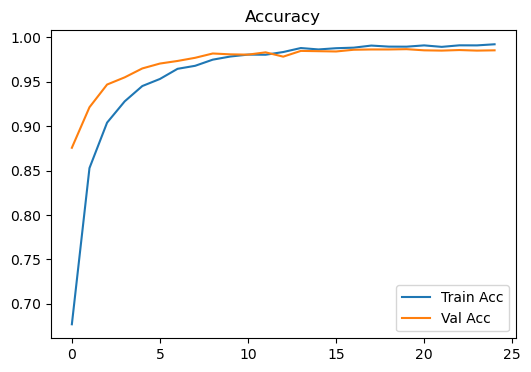

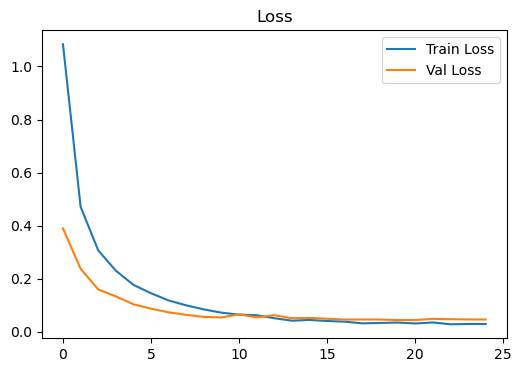

In [33]:
# Accuracy
plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend(); plt.title("Accuracy"); plt.show()

# Loss
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss"); plt.show()


In [34]:
test_loss, test_acc = resnet_model.evaluate(test_gen)
print(f"✅ Final Test Accuracy: {test_acc:.3f}, Test Loss: {test_loss:.3f}")


98/98 ━━━━━━━━━━━━━━━━━━━━ 65s 666ms/step - accuracy: 0.9868 - loss: 0.0500
✅ Final Test Accuracy: 0.987, Test Loss: 0.050


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-61.34..58.6105].


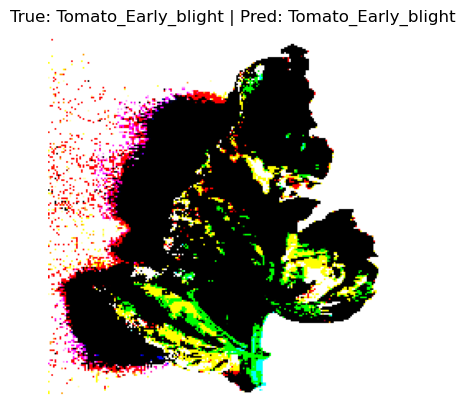

In [71]:
# Mapping index to class label
idx_to_class = {v: k for k, v in train_gen.class_indices.items()}

def show_random_prediction(model, val_gen):
    x_batch, y_batch = next(val_gen)
    idx = np.random.randint(len(x_batch))
    img = x_batch[idx]
    true_label = idx_to_class[np.argmax(y_batch[idx])]

    # ✅ Preprocess before prediction
    img_proc = np.expand_dims(img, axis=0)
    pred = model.predict(img_proc, verbose=0)
    pred_label = idx_to_class[np.argmax(pred)]

    plt.imshow((img + 1) / 2)  # ResNet preprocessing may make image dark
    plt.axis("off")
    plt.title(f"True: {true_label} | Pred: {pred_label}")
    plt.show()

show_random_prediction(resnet_model, val_gen)


In [76]:
os.makedirs("models", exist_ok=True)
resnet_model.save("D:/PlantDiseaseDetection/models/plant_disease_resnet50.keras")
print("✅ Model saved successfully!")


✅ Model saved successfully!
